springboarding from [here](http://francescopochetti.com/text-recognition-natural-scenes/), code found [here](https://github.com/FraPochetti/ImageTextRecognition/blob/master/userimageski.py)

after training a net will delete out text characters and inpaint with [this](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_photo/py_inpainting/py_inpainting.html)

In [1]:
%matplotlib inline

import numpy as np
from skimage.io import imread
from skimage.filter import threshold_otsu
from skimage.transform import resize
from matplotlib import pyplot as plt

from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage import restoration
from skimage import measure
from skimage.color import label2rgb


C:\Users\Leo\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
test_image = imread("mpv-shot0004.jpg",as_grey=True)

In [26]:
# preprocessing
image = restoration.denoise_tv_chambolle(test_image, weight=0.1)
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(2))

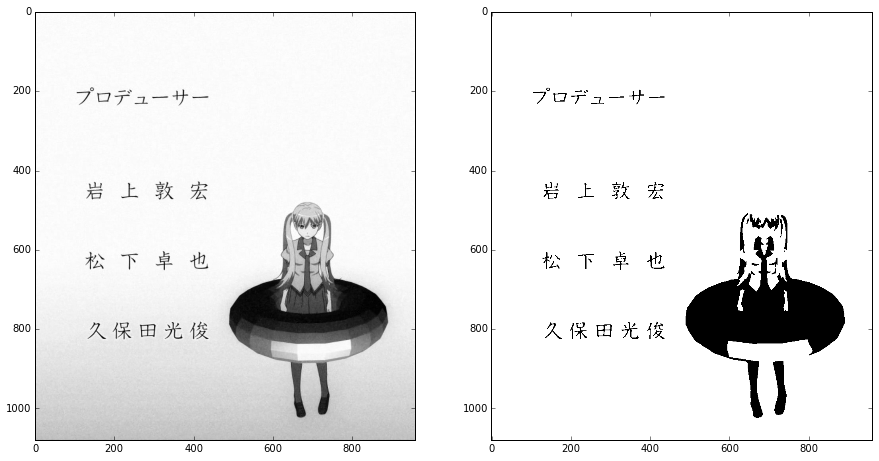

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 10))
ax[0].imshow(test_image,cmap=plt.cm.gray)
ax[1].imshow(bw,cmap=plt.cm.gray)


In [15]:
# text candidates
def get_text_candidates(original_image,bw):
    """
    identifies objects in the image. Gets contours, draws rectangles around them
    and saves the rectangles as individual images.
    """
    cleared = bw.copy()
    label_image = measure.label(bw)   
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = -1
    
    
    coordinates = []
    i=0
    
    for region in regionprops(label_image):
        if region.area > 10:
            minr, minc, maxr, maxc = region.bbox
            margin = 3
            minr, minc, maxr, maxc = minr-margin, minc-margin, maxr+margin, maxc+margin
            roi = original_image[minr:maxr, minc:maxc]
            if roi.shape[0]*roi.shape[1] == 0:
                continue
            else:
                if i==0:
                    samples = resize(roi, (20,20))
                    coordinates.append(region.bbox)
                    i+=1
                elif i==1:
                    roismall = resize(roi, (20,20))
                    samples = np.concatenate((samples[None,:,:], roismall[None,:,:]), axis=0)
                    coordinates.append(region.bbox)
                    i+=1
                else:
                    roismall = resize(roi, (20,20))
                    samples = np.concatenate((samples[:,:,:], roismall[None,:,:]), axis=0)
                    coordinates.append(region.bbox)
    
    candidates = {
                'fullscale': samples,          
                'flattened': samples.reshape((samples.shape[0], -1)),
                'coordinates': np.array(coordinates)
                }
    
    print ('Images After Contour Detection')
    print ('Fullscale: ', candidates['fullscale'].shape)
    print( 'Flattened: ',candidates['flattened'].shape)
    print( 'Contour Coordinates: ', candidates['coordinates'].shape)
    print ('============================================================')
    
    return candidates 

In [24]:
candidates = get_text_candidates(test_image,bw)

Images After Contour Detection
Fullscale:  (69, 20, 20)
Flattened:  (69, 400)
Contour Coordinates:  (69, 4)


In [18]:
def plot_to_check(what_to_plot, title):
    """
    plots images at several steps of the whole pipeline, just to check output.
    what_to_plot is the name of the dictionary to be plotted
    """
    n_images = what_to_plot['fullscale'].shape[0]
    
    fig = plt.figure(figsize=(12, 12))

    if n_images <=100:
        if n_images < 100:
            total = range(n_images)
        elif n_images == 100:
            total = range(100)
       
        for i in total:
            ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
            ax.imshow(what_to_plot['fullscale'][i], cmap="Greys_r")  
            if 'predicted_char' in what_to_plot:
                ax.text(-6, 8, str(what_to_plot['predicted_char'][i]), fontsize=22, color='red')
        plt.suptitle(title, fontsize=20)
        plt.show()  
    else:
        total = list(np.random.choice(n_images, 100)) 
        for i, j in enumerate(total):
            ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
            ax.imshow(what_to_plot['fullscale'][j], cmap="Greys_r")  
            if 'predicted_char' in what_to_plot:
                ax.text(-6, 8, str(what_to_plot['predicted_char'][j]), fontsize=22, color='red')
        plt.suptitle(title, fontsize=20)
        plt.show()   

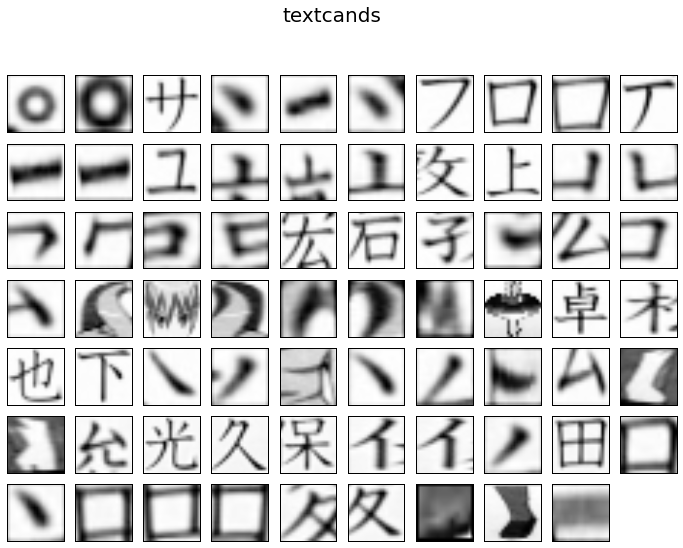

In [25]:
plot_to_check(candidates,'textcands')